In [ ]:
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from faiss import IndexFlatIP # IndexFlatL2 for cosine similarity, IndexFlatIP for dot product similarity
import numpy as np
import faiss
import os # For managing directory creation

# Ensure you have tqdm for progress bars, very helpful for long operations!
try:
    from tqdm.auto import tqdm
    tqdm.pandas()
except ImportError:
    print("tqdm not installed. Install with 'pip install tqdm' for progress bars.")

print("Libraries imported successfully.")

# Define the path to your cleaned and filtered dataset from Task 1
cleaned_data_path = '../data/filtered_and_cleaned_complaints.csv'

# Load the dataset
print(f"\nLoading cleaned data from: {cleaned_data_path}")
try:
    df_cleaned = pd.read_csv(cleaned_data_path, encoding='utf-8')
    print("Cleaned data loaded successfully.")
except Exception as e:
    print(f"Error loading cleaned data: {e}")
    print("Please ensure 'filtered_and_cleaned_complaints.csv' exists in the 'data/' directory.")
    # Exit or raise error if loading fails
    raise

print(f"Shape of the cleaned dataset: {df_cleaned.shape}")
print("\nFirst 5 rows of the cleaned dataset:")
display(df_cleaned.head())

Libraries imported successfully.

Loading cleaned data from: ../data/filtered_and_cleaned_complaints.csv
Cleaned data loaded successfully.
Shape of the cleaned dataset: (267279, 3)

First 5 rows of the cleaned dataset:


,Product,cleaned_narrative,Complaint ID
0,Mortgage,signed purchase agreement lennar corporation y...,14089944
1,Credit card,card wa opened name fraudster received notice ...,14069121
2,Credit card,dear cfpb secured credit card citibank changed...,14047085
3,Credit card,citi reward card credit balance issued wa rece...,14040217
4,Credit card,bi writing dispute following charge citi credi...,13968411



--- Step 4.5: Text Chunking Strategy ---
Prepared 267278 documents for splitting.
Splitting documents into chunks...
Total number of chunks created: 633324

--- Examples of Chunks with Metadata ---
Chunk 1:
  Content: signed purchase agreement lennar corporation year new construction home illinois wa scheduled built submitted total deposit based monthly mortgage payment estimate home price provided lennars represen...
  Metadata: {'product': 'Mortgage', 'complaint_id': 14089944, 'start_index': 0}
--------------------------------------------------
Chunk 2:
  Content: also changed multiple time raised concern lennar revoked access loan portal preventing reviewing documenting various version disclosure asked refund based error lennar refused instead stated wa defaul...
  Metadata: {'product': 'Mortgage', 'complaint_id': 14089944, 'start_index': 394}
--------------------------------------------------
Chunk 3:
  Content: requesting fund financial coercion wa pressured increase deposit base

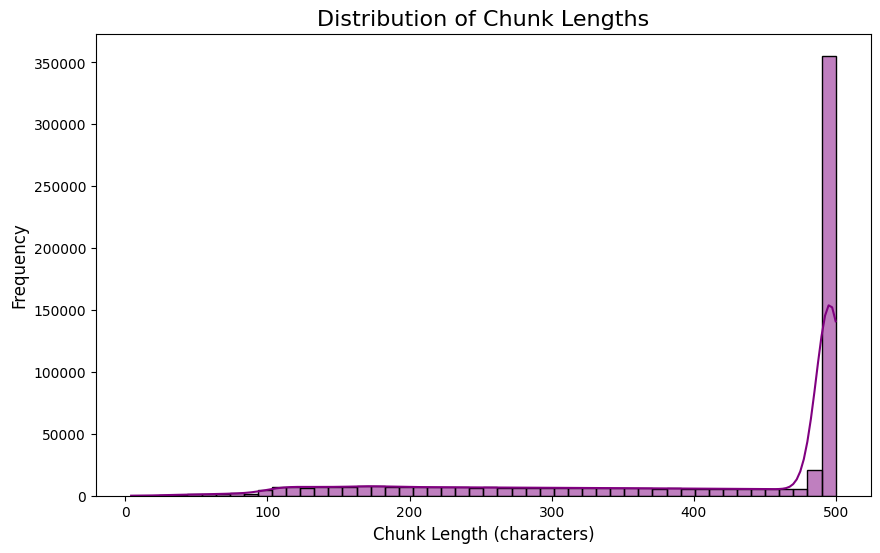


Chunks DataFrame shape: (633324, 3)


,chunk_content,product,complaint_id
0,signed purchase agreement lennar corporation y...,Mortgage,14089944
1,also changed multiple time raised concern lenn...,Mortgage,14089944
2,requesting fund financial coercion wa pressure...,Mortgage,14089944
3,card wa opened name fraudster received notice ...,Credit card,14069121
4,dear cfpb secured credit card citibank changed...,Credit card,14047085


In [4]:
print("\n--- Step 4.5: Text Chunking Strategy ---")

# Initialize the text splitter
# Experiment with these parameters!
# chunk_size: The maximum number of characters in a chunk.
# chunk_overlap: The number of characters to overlap between consecutive chunks.
#                This helps maintain context across chunks.
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # A common starting point for complaint narratives
    chunk_overlap=100, # A common starting point for overlap
    length_function=len, # Specifies that length should be measured by character count
    add_start_index=True, # Adds a metadata field for the start character index of each chunk
)

# Prepare documents for splitting: list of dictionaries
# Each dictionary should have 'page_content' (the text) and 'metadata'.
# We want to associate each chunk back to its original complaint ID and Product.
documents = []
for index, row in df_cleaned.iterrows():
    # Only process if 'cleaned_narrative' is not empty or NaN
    if pd.notna(row['cleaned_narrative']) and row['cleaned_narrative'].strip() != '':
        doc = {
            "page_content": row['cleaned_narrative'],
            "metadata": {
                "product": row['Product'],
                "complaint_id": row['Complaint ID'] # Assuming Complaint ID is in your DataFrame
            }
        }
        documents.append(doc)

print(f"Prepared {len(documents)} documents for splitting.")

# Split the documents into chunks
print("Splitting documents into chunks...")
chunks = text_splitter.create_documents([d["page_content"] for d in documents], metadatas=[d["metadata"] for d in documents])

print(f"Total number of chunks created: {len(chunks)}")

# Display a few examples of chunks
print("\n--- Examples of Chunks with Metadata ---")
for i, chunk in enumerate(chunks[:3]): # Display first 3 chunks
    print(f"Chunk {i+1}:")
    print(f"  Content: {chunk.page_content[:200]}...") # Show first 200 chars
    print(f"  Metadata: {chunk.metadata}")
    print("-" * 50)

# Analyze chunk lengths (optional but good for justification)
chunk_lengths = [len(chunk.page_content) for chunk in chunks]
print(f"\nMin chunk length: {np.min(chunk_lengths)}")
print(f"Max chunk length: {np.max(chunk_lengths)}")
print(f"Average chunk length: {np.mean(chunk_lengths):.2f}")
print(f"Median chunk length: {np.median(chunk_lengths)}")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(chunk_lengths, bins=50, kde=True, color='purple')
plt.title('Distribution of Chunk Lengths', fontsize=16)
plt.xlabel('Chunk Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Store chunks in a DataFrame for easier processing in the next step
chunks_df = pd.DataFrame([
    {
        'chunk_content': chunk.page_content,
        'product': chunk.metadata['product'],
        'complaint_id': chunk.metadata['complaint_id']
    } for chunk in chunks
])
print(f"\nChunks DataFrame shape: {chunks_df.shape}")
display(chunks_df.head())

In [5]:
print("\n--- Step 3: Choose and Load the Embedding Model ---")

# Choose an embedding model.
# 'all-MiniLM-L6-v2' is a good general-purpose model, small and fast.
# You can explore other models from SentenceTransformers documentation.
embedding_model_name = 'all-MiniLM-L6-v2'

print(f"Loading embedding model: {embedding_model_name}...")
try:
    model = SentenceTransformer(embedding_model_name)
    print("Embedding model loaded successfully.")
except Exception as e:
    print(f"Error loading embedding model: {e}")
    print("Please ensure you have an internet connection or the model is cached locally.")
    print("You might need to install 'sentence-transformers' if not already done: pip install sentence-transformers")
    raise # Re-raise the exception to stop execution if model loading fails

# You can test the model with a sample text
sample_text = "This is a test sentence for the embedding model."
sample_embedding = model.encode(sample_text)
print(f"Sample text embedding shape: {sample_embedding.shape}")


--- Step 3: Choose and Load the Embedding Model ---
Loading embedding model: all-MiniLM-L6-v2...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Error while downloading from https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


Embedding model loaded successfully.
Sample text embedding shape: (384,)


In [7]:
print("\n--- Step 4: Generate Embeddings and Create FAISS Index ---")

# Generate embeddings for all chunks
print(f"Generating embeddings for {len(chunks_df)} chunks in batches. This will be much faster...")

# OPTIMIZED LINE: Pass the entire list of chunk contents to model.encode()
# It handles batching internally for optimal performance.
list_of_chunk_contents = chunks_df['chunk_content'].tolist()
embeddings_np = model.encode(list_of_chunk_contents, show_progress_bar=True, convert_to_numpy=True)

print(f"Shape of generated embeddings: {embeddings_np.shape}")

# Initialize FAISS index
dimension = embeddings_np.shape[1] # Dimension of the embeddings (e.g., 384 for all-MiniLM-L6-v2)
faiss_index = faiss.IndexFlatIP(dimension)

# Add embeddings to the index
print("Adding embeddings to FAISS index...")
faiss_index.add(embeddings_np)
print(f"Total number of vectors in FAISS index: {faiss_index.ntotal}")

# --- Step 5: Save the FAISS Index and Metadata ---
print("\n--- Step 5: Saving the FAISS Index and Metadata ---")

# Define the directory to save the vector store
vector_store_dir = '../vector_store/'
os.makedirs(vector_store_dir, exist_ok=True)

# Define paths for the FAISS index and metadata
faiss_index_path = os.path.join(vector_store_dir, 'faiss_index.bin')
metadata_path = os.path.join(vector_store_dir, 'metadata.json')

# Save the FAISS index
print(f"Saving FAISS index to: {faiss_index_path}")
faiss.write_index(faiss_index, faiss_index_path)
print("FAISS index saved.")
 
# Save metadata (chunks_df converted to list of dictionaries)
print(f"Saving metadata to: {metadata_path}")
chunks_df.to_json(metadata_path, orient='records', indent=4)
print("Metadata saved.")
 
print("\nTask 2 Notebook execution complete. Vector store created and saved.")


--- Step 4: Generate Embeddings and Create FAISS Index ---
Generating embeddings for 633324 chunks in batches. This will be much faster...


Batches: 100%|██████████| 19792/19792 [3:40:40<00:00,  1.49it/s]      


Shape of generated embeddings: (633324, 384)
Adding embeddings to FAISS index...
Total number of vectors in FAISS index: 633324

--- Step 5: Saving the FAISS Index and Metadata ---
Saving FAISS index to: ../vector_store/faiss_index.bin
FAISS index saved.
Saving metadata to: ../vector_store/metadata.json
Metadata saved.

Task 2 Notebook execution complete. Vector store created and saved.
